## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Introducción a las redes neuronales

## Actividad 2

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

#### Nombres:

- Daniel Camilo Rojas - cod: 201924286
- Nelson Aldana Martinez - cod: 201924128

En esta actividad vamos a estudiar una primera aproximación a los modelos de redes neuronales, utilizando como base el modelo de regresión logística.


In [76]:
# Algunos paquetes iniciales que vamos a utilizar
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

## 1. Problema de clasificación: riesgo de default

Examinemos los datos con lo cuales ya estamos familiarizados:


https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

In [77]:
credit_1 = pd.read_csv("germancredit.csv")
credit_1 = pd.get_dummies(credit_1, columns=['checkingstatus1','history','purpose','savings',
                                   'employ','status','others','property','otherplans','housing','job','tele', 
                                   'foreign'], prefix = ['checkingstatus1','history','purpose','savings',
                                   'employ','status','others','property','otherplans','housing','job','tele', 
                                   'foreign'])
X = credit_1.iloc[:, 1:62]
Y = credit_1.iloc[:, 0]


In [78]:
CE_x, CP_x, CE_y, CP_y = model_selection.train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
print("Tamaño de CE, CP: ", CE_y.shape, CP_y.shape)
print("Observaciones de la clase positiva en entrenamiento: " +str(sum(CE_y)) +" y en prueba: " +str(sum(CP_y)))

Tamaño de CE, CP:  (600,) (400,)
Observaciones de la clase positiva en entrenamiento: 180 y en prueba: 120


## 2. Construcción de una neurona Sigmoide

Una neurona Sigmoide puede ser vista como un perceptrón *suavizado* que recibe una señal y entonces se activa. Al activarse, transforma la señal para entender mejor el mensaje. Esta transformación la ejecuta a partir de la fucnión Sigmoide.

Si tomamos la señal como un conjunto de datos de entrada y el mensaje como la predicción de un valor, la función de activación jugará el papel de transformadora de los datos de entrada en aquello que se quiere entender/predecir, que además replica un modelo logit con la función de activación sigmoide.

A continuación construiremos un clasificador de regresión logística bajo la perspectiva de una red neuronal, estudiando la arquitectura general de un algoritmo de aprendizaje. De esta manera, necesitaremos incluir la inicialización de los parámetros, el cálculo de la función de coste y su gradiente, y utilizar un algoritmo de optimización como por ejemplo el descenso en la dirección del gradiente (GD)

**Formulación del algoritmo**:

Para un ejemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoide(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

El coste se calcula sumando sobre todos los ejemplos de entrenamiento:
$$ L = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$



### Construimos las partes del algoritmo  

- Inicializar los parámetros del modelo
- Bucle:
    - Calcular la pérdida actual (propagación hacia delante)
    - Calcular el gradiente actual (retro-propagación)
    - Actualizar los parámetros (descenso en la dirección del gradiente)


### Ejercicio 2.1
Implemente la funcion `sigmoide()` $$\sigma( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$ Para ello puede utilizar np.exp().

In [79]:
def sigmoide(z):
    """
    Input:
    z: Un escalar o arreglo numpy de cualquier tamaño
    Output:
    s: sigmoid(z)
    """

    s = 1/(1+np.exp(-z))
    
    return s

In [80]:
print ("sigmoide([99,1,0,-1,-99]) = " + str(sigmoide(np.array([99,1,0,-1,-99]))))

sigmoide([99,1,0,-1,-99]) = [1.00000000e+00 7.31058579e-01 5.00000000e-01 2.68941421e-01
 1.01122149e-43]


**Salida esperada**: 

<table>
<tr>
<td> sigmoide([99,1,0,-1,-99])    = </td>
<td> [ 1.00000000e+00 7.31058579e-01 5.00000000e-01 2.68941421e-01
 1.01122149e-43] </td> 
</tr>
</table>

### Ejercicio 2.2 

Debemos inicializar los parámetros a cero. Puede utilizar la funcion np.zeros(), apoyandose en la documentación de la biblioteca Numpy.

In [81]:
def inicializa_ceros(dim):
    """
    Esta función crea un vector de ceros de dimensión (dim, 1) para w e inicializa b a 0.
    Input:
    dim: tamaño del vector w (número de parámetros para este caso)
    Output:
    w: vector inicializado de tamaño (dim, 1)
    b: escalar inicializado (corresponde con el sesgo)
    """
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [82]:
dim = 6
w, b = inicializa_ceros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
b = 0


**Salida esperada**: 


<table style="width:35%">
<tr>
<td>   w   </td>
<td> [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] </td>
</tr>
<tr>
<td>   b   </td>
<td> 0 </td>
</tr>
</table>

### Ejercicio 2.3 
#### Propagación hacia delante y hacia atrás

Una vez los estimadores están inicializados, se pueden implementar los pasos de propagación hacia "delante" y hacia "atrás" para el aprendizaje automático. 

La propagación hacia delante consiste en calcular la función de activación sigmoide sobre la combinacón lineal de los patrones y los coeficientes inciales. 

Luego la propagación hacia atrás, o *retro-propagación*, es el paso más importante, donde utilizamos el gradiente de la función del error o de pérdida para actualizar los coeficientes. 

Este procedimiento se repite iterativamente replicando el procediemiento de descenso en la dirección del gradiente o *Gradient Descent* (GD).

A continuación implemente la función `propaga()` que calcula la función de coste y su gradiente.

**Ayuda**:

Propagación hacia delante:
- Se tiene $X$
- Se calcula $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Se calcula la función de coste/pérdida: $L = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Para la retro-propagación, tenemos que calcular la derivada parcial de *L* con respecto a nuestros coeficientes $(w,b)$:  

$$ \frac{\partial L}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

*Nota:* Para el cálculo de estas derivadas debemos hacer uso de la regla de la cadena. 

Esto es, dado $Z=w^T X + b$, se tiene que $$\frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \frac{\partial A}{\partial Z} = \bigg(\frac{-Y}{A}+\frac{1-Y}{1-A}\bigg) (A \cdot (1-A)) $$


In [83]:
def propaga(w, b, X, Y):
    """
    Implemente la función de coste y su gradiente para la propagación
    Input:
    w: pesos, un arreglo numpy 
    b: sesgo, un escalar
    X: datos de entrada
    Y: vector de etiquetas 
    Output:
    coste: coste negativo de log-verosimilitud para la regresión logística
    dw: gradiente de la pérdida con respecto a w, con las mismas dimensiones que w
    db: gradiente de la pérdida con respecto a b, con las mismas dimensiones que b
    
    (Sugerencia: utilice las funciones np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    A = sigmoide(np.dot(np.transpose(w),X)+b)                    # compute la activación
    coste = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))              # compute el coste

    dw = 1/m*np.dot(X,np.transpose(A-Y))
    db = 1/m*np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(coste)
    assert(coste.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, coste

In [84]:
w, b, X, Y = np.array([[0.1],[0.1]]), 0.5, np.array([[66.,99.,-33.],[32.,55.,-2.1]]), np.array([[0,0,1]])
grads, coste = propaga(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("coste = " + str(coste))

dw = [[65.48251839]
 [29.66675568]]
db = 0.348980796447886
coste = 9.752716367426284


**Salida esperada**: 

<table style="width:50%">
<tr>
<td>   dw   </td>
<td> [[65.48251839]
 [29.66675568]]</td>
</tr>
<tr>
<td>   db   </td>
<td> 0.348980796447886 </td>
</tr>
<tr>
<td>   cost   </td>
<td> 9.752716367426284 </td>
</tr>
</table>

### Ejercicio 2.4 
#### Optimización

- Se tienen los parámetros inicializados.
- También se tiene el código para calcular la función de coste y su gradiente.
- Ahora se quieren actualizar los parámetros utilizando el GD.

Escriba la función de optimización para aprender $w$ y $b$ minimizando la función de coste $L$. 

Para un parámetro $\theta$, la regla de actualización es $ \theta = \theta - \alpha \text{ } d\theta$, donde $\alpha$ es la tasa de aprendizaje.

In [85]:
def optimiza(w, b, X, Y, num_iter, tasa, print_cost):
    """
    Esta función optimiza w y b implementando el algoritmo de GD
    Input:
    w: pesos, un arreglo numpy 
    b: sesgo, un escalar
    X: datos de entrada
    Y: vector de etiquetas 
    num_iter: número de iteracionespara el bucle de optimización
    tasa: tasa de aprendizaje para la regla de actualización del GD
    print_cost: True para imprimir la pérdida cada 100 iteraciones
    Output:
    params: diccionario con los pesos w y el sesgo b
    grads: diccionario con los gradientes de los pesos y el sesgo con respecto a la función de pérdida
    costes: lista de todos los costes calculados durante la optimización, usados para graficar la curva de aprendizaje.
    
    Sugerencia: puede escribir dos pasos e iterar sobre ellos:
        1) Calcule el coste y el gradiente de los parámetros actuales. Use propaga().
        2) Actualize los parámetros usando la regla del GD para w y b.
    """
    
    costes = []
    
    for i in range(num_iter):
        
        
        # Computación del coste y el gradiente 
        grads, coste = propaga(w, b, X, Y)
        
        # Recupere las derivadas de grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Actualize la regla 
        w = w - tasa * dw
        b = b - tasa * db
        
        # Guarde los costes
        if i % 100 == 0:
            costes.append(coste)
        
        # Se muestra el coste cada 100 iteraciones de entrenamiento
        if print_cost and i % 100 == 0:
            print ("Coste tras la iteración %i: %f" %(i, coste))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costes

In [86]:
params, grads, costes = optimiza(w, b, X, Y, num_iter= 10, tasa = 0.001, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[-0.07262234]
 [ 0.02112647]]
b = 0.49898148713402446
dw = [[1.42076721]
 [0.43496446]]
db = -0.007821662502973652


**Salida esperada**:  

<table style="width:40%">
<tr>
<td> w </td>
<td>[[-0.07262234]
 [ 0.02112647]] </td>
</tr>
<tr>
<td> b </td>
<td> 0.49898148713402446 </td>
</tr>
<tr>
<td> dw </td>
<td> [[1.42076721]
 [0.43496446]] </td>
</tr>
<tr>
<td> db </td>
<td> -0.007821662502973652 </td>
</tr>
</table>

### Ejercicio 2.5

La función anterior aprende los parámetros w y b, que se pueden usar para predecir sobre el conjunto de datos X. 

Hay dos pasos para calcular las predicciones:

1. Calcular $\hat{Y} = A = \sigma(w^T X + b)$

2. Converir a 0 las entradas de $a$ (si la activación es <= 0.5) o 1 (si la activación es > 0.5), guarde las predicciones en un vector `Y_pred`.  

Ahora implemente la función `pred()`. 

In [87]:
def pred(w, b, X):
    '''
    Prediga si una etiqueta es 0 o 1 usando los parámetros de regresión logística aprendidos (w, b)
    Input:
    w: pesos, un arreglo numpy 
    b: sesgo, un escalar
    X: datos de entrada
    Output:
    Y_pred: vector con todas las predicciones (0/1) para los ejemplos en X
    '''
    
    m = X.shape[1]
    Y_pred = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute el vector "A" prediciendo las probabilidades de que la imagen contenga un frailejon
    A = sigmoide(np.dot(np.transpose(w),X)+b)
    
    for i in range(A.shape[1]):
        
        # Convierta las probabilidades A[0,i] a predicciones p[0,i]
        Y_pred[0,i] = round(A[0,i],0)
    
    assert(Y_pred.shape == (1, m))
    
    return Y_pred

In [88]:
w = np.array([[0.12],[0.23]])
b = -0.09
X = np.array([[3.1,-2.9,0.2],[1.9,1.8,-0.09]])
print ("predicciones = " + str(pred(w, b, X)))

predicciones = [[1. 0. 0.]]


**Salida esperada**: 

<table style="width:40%">
<tr>
<td> predicciones   </td>
<td>[[ 1.  0.  0.]]  </td>  
</tr>
</table>

### Ejercicio 2.6
#### Combine todas las funciones 

Ahora juntemos todos los bloques que ha programado arriba.

Implemente la función del modelo "madre". Use la siguiente notación:
    - YP_pred para las predicciones sobre el conjunto de prueba
    - YE_pred para las predicciones sobre el conjunto de entrenamiento
    - w, costes, grads para las salidas de optimiza()

In [89]:
def modelo(CE_x, CP_x, CE_y, CP_y, num_iter, tasa, print_cost):
    """
    Construye el modelo de regresión logística llamando las funciones implementadas anteriormente
    Output:
    d: diccionario con la información sobre el modelo.
    """
    
    # Inicialice los parametros con ceros 
    dim = CE_x.shape[0]
    w, b = inicializa_ceros(dim)

    # Descenso en la dirección del gradiente (GD) 
    params, grads, costes = optimiza(w, b, CE_x, CE_y, num_iter, tasa, print_cost)
    
    # Recupere los parámetros w y b del diccionario "params" ##
    w = params["w"]
    b = params["b"]
    
    # Prediga los ejemplos de prueba y entrenamiento (≈ 2 líneas de código)
    YP_pred = pred(w,b,CP_x)
    YE_pred = pred(w,b,CE_x)

    # Imprima los errores de entrenamiento y prueba
    print("Accuracy de entrenamiento: {} %".format(100 - np.mean(np.abs(YE_pred - CE_y)) * 100))
    print("Accuracy de prueba: {} %".format(100 - np.mean(np.abs(YP_pred - CP_y)) * 100))

    
    d = {"Costes": costes,
         "Prediccion_prueba": YP_pred, 
         "Prediccion_entrenamiento" : YE_pred, 
         "w" : w, 
         "b" : b,
         "Tasa de aprendizaje" : tasa,
         "Numero de iteraciones": num_iter}
    
    return d

### Pregunta 2.7

De qué dimensiones deben ser las matrices con los datos de entrada y de salida?

In [90]:
# Podemos re-configurar las matrices de la siguiente forma:
CE_x2 = CE_x.T
CP_x2 = CP_x.T
CE_y2 = np.array(CE_y)[np.newaxis]
CP_y2 = np.array(CP_y)[np.newaxis]

print(CE_x2.shape, CE_y2.shape)

(61, 600) (1, 600)


Ahora, ejecute la siguiente celda para entrenar el modelo:

In [91]:
d = modelo(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = 1000, tasa = 1e-6, print_cost = True)

Coste tras la iteración 0: 0.693147
Coste tras la iteración 100: 0.678157
Coste tras la iteración 200: 0.677031
Coste tras la iteración 300: 0.675938
Coste tras la iteración 400: 0.674877
Coste tras la iteración 500: 0.673846
Coste tras la iteración 600: 0.672844
Coste tras la iteración 700: 0.671871
Coste tras la iteración 800: 0.670925
Coste tras la iteración 900: 0.670005
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %


**Salida esperada**: 

<table style="width:50%"> 
<tr>
<td> Coste tras la iteración 0   </td> 
<td> 0.693147 </td>
</tr>
<tr>
<td> <center> $\vdots$ </center> </td> 
<td> <center> $\vdots$ </center> </td> 
</tr>  
<tr>
<td> Precisión de entrenamiento  </td> 
<td> 70.0 % </td>
</tr>
<tr>
<td> Precisión de prueba </td> 
<td> 70.0 % </td>
</tr>
</table> 

La precisión de entrenamiento es muy similar a la que conseguimos mediante la regresion logistica. También podemos observar que el error de prueba es igual al de entrenamiento. Este resultado sugiere que el modelo aprende segun entrenamiento, y generaliza de igual forma sobre los observaciones nuevas.

Grafiquemos la función de pérdida.

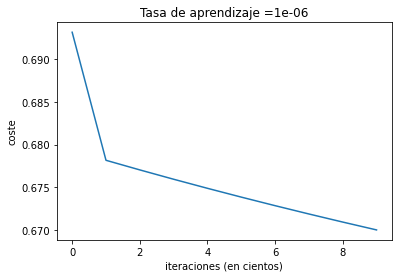

In [92]:
# Gráfica de la curva de aprendizaje (con costes)
costes = np.squeeze(d['Costes'])
plt.plot(costes)
plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')
plt.title("Tasa de aprendizaje =" + str(d["Tasa de aprendizaje"]))
plt.show()

**Interpretación**:
Se puede ver el coste decreciendo, demostrando que los parámetros están siendo aprendidos. 

Ya tenemos un primer modelo de clasificación. Ahora examinemos distintos valores para la tasa de aprendizaje $\alpha$. 

#### Selección de la tasa de aprendizaje ####

Para que el método del GD funcione de manera adecuada, se debe elegir la tasa de aprendiazaje de manera acertada. Esta tasa $\alpha$  determina qué tan rápido se actualizan los parámetros. Si la tasa es muy grande se puede "sobrepasar" el valor óptimo. Y de manera similar, si es muy pequeña se van a necesitar muchas iteraciones para converger a los mejores valores. Por ello la importancia de tener una tase de aprensizaje bien afinada.  

Ahora, comparemos la curva de aprendizaje de nuestro modelo con distintas elecciones para $\alpha$. Ejecute el código abajo. También puede intentar con valores distintos a los tres que estamos utilizando abajo para `tasas` y analize los resultados.



La tasa de aprendizaje es: 0.0001


<ipython-input-4-bd0ffb3a48e4>:9: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-z))
<ipython-input-41-e4809b734f4f>:20: RuntimeWarning: divide by zero encountered in log
  coste = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))              # compute el coste
<ipython-input-41-e4809b734f4f>:20: RuntimeWarning: invalid value encountered in multiply
  coste = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))              # compute el coste


Accuracy de entrenamiento: 33.0 %
Accuracy de prueba: 32.75 %

-------------------------------------------------------

La tasa de aprendizaje es: 1e-06
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 1e-10
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 2e-20
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------



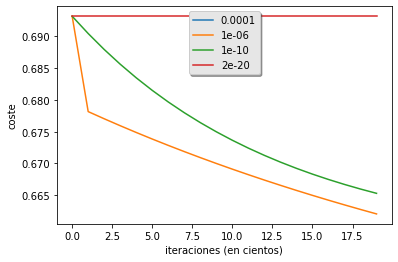

In [57]:
tasas = [1e-4, 1e-6, 1e-10, 2e-20]
modelos = {}
for i in tasas:
    print ("La tasa de aprendizaje es: " + str(i))
    modelos[str(i)] = modelo(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = 2000, tasa = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in tasas:
    plt.plot(np.squeeze(modelos[str(i)]["Costes"]), label= str(modelos[str(i)]["Tasa de aprendizaje"]))

plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

### Pregunta 2.8

Analice los resultados, con cuál tasa de aprendizaje intentaría mejorar el desempeño del modelo?

Teniendo en cuenta los resultados obtenidos, la mejor tasa de aprendizaje es 1e-06, debido a que es la que mejores resultados arroja a medida que avanzan las iteraciones. Entre menor sea la tasa de aprendizaje, es posible que se logre mejorar el desempeño del modelo, sin embargo, para lograr esto debería aumentarse el número de iteraciones. Esto se debe a que para llegar al mínimo error, el cambio de los paramétros están siendo más pequeños, aumentando así el tiempo de convergencia.

Ahora bien, cabe decir que cuando la tasa de aprendizaje es muy grande, el modelo puede converger más rápido, sin embargo, cabe la posibilidad de que no llegue al punto óptimo.

## 3. Comparacion con la implementación tradicional de regresión logística

A continuación ajustamos el modelo logístico y lo probamos:

In [58]:
logT = LogisticRegression(penalty='none', max_iter=1500)
logT.fit(CE_x, CE_y)
y_tr = logT.predict(CE_x)
y_pred = logT.predict(CP_x)

Examinemos los coeficientes del modelo de la neurona sigmoide y su desviación con respecto a la estimación tradicional de regresion logistica.

In [66]:
from astropy.table import QTable, Table, Column

Tabla =  Table([logT.coef_.T, d['w'], logT.coef_.T- d['w']], names=("Regresion logistica", "Neurona sigmoide", "Diferencia"))
Tabla

Regresion logistica [1],Neurona sigmoide [1],Diferencia [1]
float64,float64,float64
0.02107730052974706,-6.293083905403865e-05,0.021140231368801096
0.00010277130807963354,-1.6311369074005705e-05,0.00011908267715363924
0.31548172497762395,-0.0001513506113979065,0.31563307558902187
0.01798263211466749,-0.0001679441361110126,0.0181505762507785
-0.008123102635889242,-0.0023681544427456122,-0.005754948193143631
0.15052602241061147,-8.57418462456453e-05,0.15061176425685713
0.07301694407877354,-6.586234732681293e-05,0.07308280642610035
0.5647545734988375,2.9167410750735905e-05,0.5647254060880867
0.1261362521846937,8.429711287300679e-06,0.1261278224734064


### Pregunta 3.1

Qué puede observar en esta comparativa?

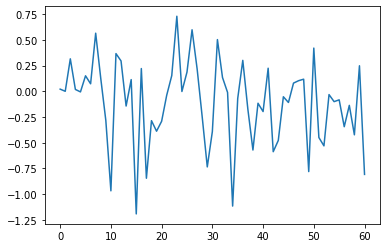

In [75]:
plt.plot(Tabla['Diferencia'])
plt.show()

Existe una alta diferencia entre los parámetros generados por los dos modelos. Esto debido a que la regresión logística calcula los parámetros con base en la metodología de máxima verosimilitud, por su parte la red neuronal, tiene una inicialización aleatoria de los parámetros y converge con base en cambios de estos a medida que van pasando las épocas.

Veamos la exactitud de los modelos

In [73]:
print("La neurona sigmoide tiene una exactitud de entrenamiento: " 
      +str(float((d['Prediccion_entrenamiento'] == CE_y2).mean())) +" y de validacion: " +str(float((d['Prediccion_prueba'] == CP_y2).mean())))
print("La regresion tradicional tiene una exactitud de entrenamiento: " 
      +str(float((y_tr == CE_y).mean())) +" y de validacion: " +str(float((y_pred == CP_y).mean())))


La neurona sigmoide tiene una exactitud de entrenamiento: 0.7 y de validacion: 0.7
La regresion tradicional tiene una exactitud de entrenamiento: 0.785 y de validacion: 0.76


### Ejercicio  3.2

Ahora puede desarrollar su propio código intentando mejorar los resultados obtenidos. 

Intente sobrepasar los resultados de la regresion logistica tradicional. Optimice la tasa de aprendizaje, el número de iteraciones o (bono) investigue y cambie la manera en la cual inicializamos los coeficientes. 

## Cambio de tasas de aprendizaje

En primer lugar se cambiaran las tasas de aprendizaje, con el fin de evaluar si el acurracy del modelo sea más grande. Con esto podemos concluir que aunque se cambien, sigue estando al rededor del 70%. El mejor acurracy, se obtuvo con una tasa de aprendizaje de 1e-06.

- La tasa de aprendizaje es: 1e-06
- Accuracy de entrenamiento: 67.16666666666667 %
- Accuracy de prueba: 70.25 %

La tasa de aprendizaje es: 1


<ipython-input-79-bd0ffb3a48e4>:9: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-z))
<ipython-input-83-e4809b734f4f>:20: RuntimeWarning: divide by zero encountered in log
  coste = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))              # compute el coste
<ipython-input-83-e4809b734f4f>:20: RuntimeWarning: invalid value encountered in multiply
  coste = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))              # compute el coste


Accuracy de entrenamiento: 33.16666666666667 %
Accuracy de prueba: 33.5 %

-------------------------------------------------------

La tasa de aprendizaje es: 0.1
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 0.01
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 0.001
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

La tasa de aprendizaje es: 0.0001
Accuracy de entrenamiento: 33.16666666666667 %
Accuracy de prueba: 33.5 %

-------------------------------------------------------

La tasa de aprendizaje es: 1e-06
Accuracy de entrenamiento: 67.16666666666667 %
Accuracy de prueba: 70.25 %

-------------------------------------------------------

La tasa de aprendizaje es: 1e-10
Accuracy de entrenamiento: 70.0 %
Accuracy de prue

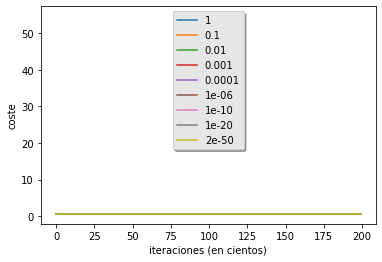

In [95]:
tasas = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-6, 1e-10, 1e-20, 2e-50]
modelos = {}
for i in tasas:
    print ("La tasa de aprendizaje es: " + str(i))
    modelos[str(i)] = modelo(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = 2000, tasa = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in tasas:
    plt.plot(np.squeeze(modelos[str(i)]["Costes"]), label= str(modelos[str(i)]["Tasa de aprendizaje"]))

plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## Cambio en el número de iteraciones

Ahora se procede a cambiar el número de iteraciones, con la tasa de aprendizaje óptima del ejercicio anterior (1e-06), se observa que el número de iteraciones con mejor desempeño en el acurracy de prueba son 6000, obteniendo una medida de 71.5%

- El número de iteraciones es: 6000
- Accuracy de entrenamiento: 70.33333333333333 %
- Accuracy de prueba: 71.5 %

El número de iteraciones es: 2000
Accuracy de entrenamiento: 70.0 %
Accuracy de prueba: 70.0 %

-------------------------------------------------------

El número de iteraciones es: 6000
Accuracy de entrenamiento: 70.33333333333333 %
Accuracy de prueba: 71.5 %

-------------------------------------------------------

El número de iteraciones es: 10000
Accuracy de entrenamiento: 69.5 %
Accuracy de prueba: 70.75 %

-------------------------------------------------------

El número de iteraciones es: 14000
Accuracy de entrenamiento: 68.0 %
Accuracy de prueba: 71.0 %

-------------------------------------------------------

El número de iteraciones es: 18000
Accuracy de entrenamiento: 67.83333333333334 %
Accuracy de prueba: 70.5 %

-------------------------------------------------------

El número de iteraciones es: 22000
Accuracy de entrenamiento: 67.0 %
Accuracy de prueba: 69.75 %

-------------------------------------------------------

El número de iteraciones es: 26000
Accuracy de ent

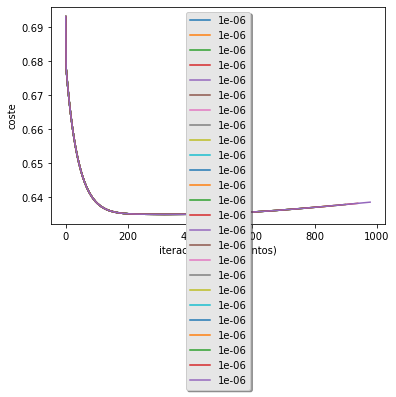

In [97]:
inter = range(2000,100000,4000)
modelos = {}
for i in inter:
    print ("El número de iteraciones es: " + str(i))
    modelos[str(i)] = modelo(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = i, tasa = 1e-6, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in inter:
    plt.plot(np.squeeze(modelos[str(i)]["Costes"]), label= str(modelos[str(i)]["Tasa de aprendizaje"]))

plt.ylabel('coste')
plt.xlabel('iteraciones (en cientos)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## Inicializando los parámetros aleatoriamente

A continuación se define el modelo completamente, inicializando los paramétros de manera aleatoria, para evaluar si de esta forma mejora el acurracy.

In [107]:
def inicializa_random(dim):
    """
    Esta función crea un vector de ceros de dimensión (dim, 1) para w e inicializa b a 0.
    Input:
    dim: tamaño del vector w (número de parámetros para este caso)
    Output:
    w: vector inicializado de tamaño (dim, 1)
    b: escalar inicializado (corresponde con el sesgo)
    """
    
    w = np.random.randn(dim,1)
    b = 0*np.random.randn()

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [108]:
def modelo_random(CE_x, CP_x, CE_y, CP_y, num_iter, tasa, print_cost):
    """
    Construye el modelo de regresión logística llamando las funciones implementadas anteriormente
    Output:
    d: diccionario con la información sobre el modelo.
    """
    
    # Inicialice los parametros con ceros 
    dim = CE_x.shape[0]
    w, b = inicializa_random(dim)

    # Descenso en la dirección del gradiente (GD) 
    params, grads, costes = optimiza(w, b, CE_x, CE_y, num_iter, tasa, print_cost)
    
    # Recupere los parámetros w y b del diccionario "params" ##
    w = params["w"]
    b = params["b"]
    
    # Prediga los ejemplos de prueba y entrenamiento (≈ 2 líneas de código)
    YP_pred = pred(w,b,CP_x)
    YE_pred = pred(w,b,CE_x)

    # Imprima los errores de entrenamiento y prueba
    print("Accuracy de entrenamiento: {} %".format(100 - np.mean(np.abs(YE_pred - CE_y)) * 100))
    print("Accuracy de prueba: {} %".format(100 - np.mean(np.abs(YP_pred - CP_y)) * 100))

    
    d = {"Costes": costes,
         "Prediccion_prueba": YP_pred, 
         "Prediccion_entrenamiento" : YE_pred, 
         "w" : w, 
         "b" : b,
         "Tasa de aprendizaje" : tasa,
         "Numero de iteraciones": num_iter}
    
    return d

In [112]:
e = modelo_random(CE_x2, CP_x2, CE_y2, CP_y2, num_iter = 6000, tasa = 1e-6, print_cost = True)

<ipython-input-79-bd0ffb3a48e4>:9: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-z))
<ipython-input-83-e4809b734f4f>:20: RuntimeWarning: divide by zero encountered in log
  coste = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))              # compute el coste
<ipython-input-83-e4809b734f4f>:20: RuntimeWarning: invalid value encountered in multiply
  coste = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))              # compute el coste


Coste tras la iteración 0: nan
Coste tras la iteración 100: nan
Coste tras la iteración 200: nan
Coste tras la iteración 300: nan
Coste tras la iteración 400: nan
Coste tras la iteración 500: nan
Coste tras la iteración 600: nan
Coste tras la iteración 700: nan
Coste tras la iteración 800: nan
Coste tras la iteración 900: nan
Coste tras la iteración 1000: 15.530991
Coste tras la iteración 1100: 4.111906
Coste tras la iteración 1200: 4.107968
Coste tras la iteración 1300: 4.104031
Coste tras la iteración 1400: 4.100097
Coste tras la iteración 1500: 4.096165
Coste tras la iteración 1600: 4.092235
Coste tras la iteración 1700: 4.088307
Coste tras la iteración 1800: 4.084381
Coste tras la iteración 1900: 4.080458
Coste tras la iteración 2000: 4.076537
Coste tras la iteración 2100: 4.072618
Coste tras la iteración 2200: 4.068701
Coste tras la iteración 2300: 4.064787
Coste tras la iteración 2400: 4.060875
Coste tras la iteración 2500: 4.056965
Coste tras la iteración 2600: 4.053058
Coste tr

En conclusión, de acuerdo a las pruebas realizadas, se define que el mejor modelo puede ser obtenido por un parámetro aleatorio, sin embargo, al ser de esta naturaleza, es un ensayo de prueba y error.

Por otro lado, con las pruebas de iteraciones y de tasa de aprendizaje, se obtuvo un acurracy del 71.5%, con un modelo de 6000 iteraciones y una tasa de aprendizaje igual a 1e-06. 

Concluyendo que con esta red neuronal de una sola capa está acercandose a los valores logrados, por lo que se sugiere buscar con redes neuronales de más capas o con diferentes funciones de activación, para de esta manera lograr superar los valores obtenidos con la regresión logística.